In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset
import torchvision.transforms as tfms
from PIL import Image
import random
from tqdm import trange
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from torch import nn, optim
import torch
import numpy as np
from tqdm import tqdm
import open_clip
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
from sklearn.model_selection import train_test_split
import os.path as osp
from transformers import CLIPModel, AutoProcessor
import matplotlib.pyplot as plt
import torch.nn.functional as F

torch.set_num_threads(5)   # Sets the number of threads used for intra-operations
torch.set_num_interop_threads(5)   # Sets the number of threads used for inter-operations

import open_clip

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 1


def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

model_name = "hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"
MOE_model, MOE_preprocess = open_clip.create_model_from_pretrained(model_name)
MOE_model = MOE_model.to(device)
MOE_model = MOE_model.eval()
MOE_tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
model,_, preprocess =  open_clip.create_model_and_transforms("ViT-L-14", pretrained='laion2b_s32b_b82k') #ViTB/32
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-L-14')
seed_everything(1024)



def get_transform():
    transform = tfms.Compose([
        tfms.Resize((224,224)),
        tfms.ToTensor(),
        tfms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform

class ConfounderDataset(Dataset):
    def __init__(self, root_dir,
                 target_name, confounder_names,
                 model_type=None, augment_data=None):
        
        raise NotImplementedError

    def __len__(self):
        if self.split == 'train':
            return len(self.training_sample)
        if self.split == 'val':
            return len(self.valid_sample)
        if self.split == 'test':
            return len(self.test_sample)

    def __getitem__(self, idx):
        if self.split == 'train': 
            y = self.training_sample_y_array[idx]
            y = torch.tensor(y)
            a = self.training_sample_confounder_array[idx]
            a = torch.tensor(a)
            img_filename = os.path.join(
                self.data_dir,
                self.training_sample[idx]) 
            img = Image.open(img_filename).convert('RGB')
            x = preprocess(img)
            img_for_res = self.transform(img)
            
            
        elif self.split == 'val': 
            y = self.valid_sample_y_array[idx]
            y = torch.tensor(y)
            a = self.valid_sample_confounder_array[idx]
            a = torch.tensor(a)
            img_filename = os.path.join(
                self.data_dir,
                self.valid_sample[idx])       
            img = Image.open(img_filename).convert('RGB')
            x = preprocess(img)
            img_for_res = self.transform(img)
            
        elif self.split == 'test': 
            y = self.test_sample_y_array[idx]
            a = self.test_sample_confounder_array[idx]
            y = torch.tensor(y)
            a = torch.tensor(a)
            img_filename = os.path.join(
                self.data_dir,
                self.test_sample[idx])       
            img = Image.open(img_filename).convert('RGB')
            x = preprocess(img)
            img_for_res = self.transform(img)
            
        return x,y,a, img_for_res



    
class ISICDataset(ConfounderDataset):
    def __init__(self, 
                 root_dir,
                 seed,
                 split,
                 target_name = ['label'], 
                 confounder_names=['patches'],
                 model_type=None,
                 augment_data=False,
                 mix_up=False,
                 group_id=None,
                 id_val=True):
        self.split = split
        self.augment_data = augment_data
        self.group_id = group_id
        self.mix_up = mix_up
        self.model_type = model_type
        self.target_name = target_name
        self.confounder_names = confounder_names
        self.split_dir = osp.join(root_dir, 'trap-sets')
        self.data_dir = osp.join(root_dir, 'ISIC2018_Task1-2_Training_Input')
        
        metadata = {}
        metadata['train'] = pd.read_csv(osp.join(self.split_dir, f'isic_annotated_train{seed}.csv'))
        if id_val:
            test_val_data = pd.read_csv(osp.join(self.split_dir, f'isic_annotated_test{seed}.csv'))
            idx_val, idx_test = train_test_split(np.arange(len(test_val_data)), 
                                                test_size=0.8, random_state=0)
            metadata['test'] = test_val_data.iloc[idx_test]
            metadata['val'] = test_val_data.iloc[idx_val]
        else:
            metadata['test'] = pd.read_csv(osp.join(self.split_dir, f'isic_annotated_test{seed}.csv'))
            metadata['val'] = pd.read_csv(osp.join(self.split_dir, f'isic_annotated_val{seed}.csv'))
            # subtracting two dataframes 
            metadata_new = metadata['train'].merge(metadata['val'], how='left', indicator=True)
            metadata_new = metadata_new[metadata_new['_merge'] == 'left_only']
            metadata['train'] = metadata_new.drop(columns=['_merge'])
        
        
        self.precomputed = False
        self.pretransformed = False
        self.n_classes = 2
        self.n_confounders = 1
        confounder = confounder_names[0]
        
        self.training_sample = metadata['train']['image'].values
        self.training_sample_y_array = metadata['train'][target_name].values
        self.training_sample_confounder_array = metadata['train'][confounder].values
        
        self.valid_sample = metadata['val']['image'].values
        self.valid_sample_y_array = metadata['val'][target_name].values
        self.valid_sample_confounder_array = metadata['val'][confounder].values
        
        self.test_sample = metadata['test']['image'].values
        self.test_sample_y_array = metadata['test'][target_name].values
        self.test_sample_confounder_array = metadata['test'][confounder].values
        self.transform = get_transform()
        

    
data_dir =r"../../../Dataset/data/ISIC/isic"
seed = 1

training_isic_dataset  = ISICDataset(data_dir, seed, 'train')
valid_isic_dataset  = ISICDataset(data_dir, seed, 'val')
test_isic_dataset  = ISICDataset(data_dir, seed, 'test')


training_data_loader  = torch.utils.data.DataLoader(dataset = training_isic_dataset,
                                                batch_size= batch_size,
                                                shuffle=True,
                                                num_workers=0)

valid_data_loader  = torch.utils.data.DataLoader(dataset = valid_isic_dataset,
                                                batch_size= batch_size,
                                                shuffle=False,
                                                num_workers=0)

test_data_loader  = torch.utils.data.DataLoader(dataset = test_isic_dataset,
                                                batch_size= batch_size,
                                                shuffle=False,
                                                num_workers=0)
print('Done')

Done


general_embeddings torch.Size([1, 768])


Testing:   0%|                                                                                  | 0/618 [00:00<?, ?it/s]

<Figure size 1000x500 with 0 Axes>

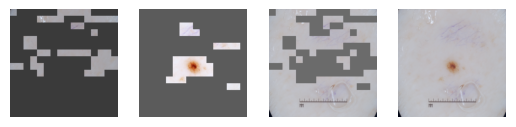

Testing:   0%|                                                                          | 1/618 [00:00<05:59,  1.71it/s]

<Figure size 1000x500 with 0 Axes>

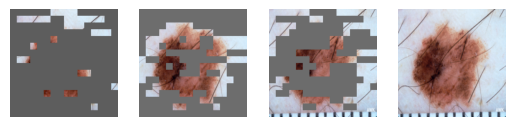

Testing:   0%|▏                                                                         | 2/618 [00:01<08:57,  1.15it/s]

<Figure size 1000x500 with 0 Axes>

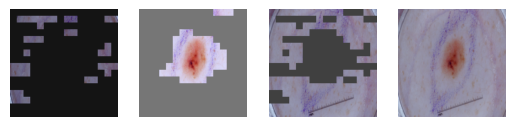

Testing:   0%|▎                                                                         | 3/618 [00:02<06:31,  1.57it/s]

<Figure size 1000x500 with 0 Axes>

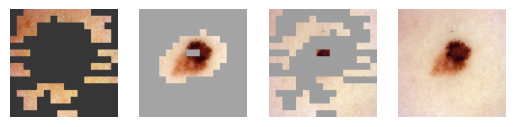

Testing:   1%|▍                                                                         | 4/618 [00:02<05:05,  2.01it/s]

<Figure size 1000x500 with 0 Axes>

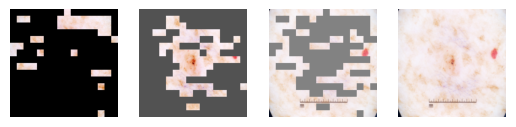

Testing:   1%|▌                                                                         | 5/618 [00:02<04:55,  2.07it/s]

<Figure size 1000x500 with 0 Axes>

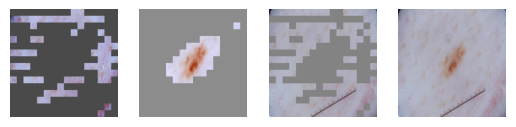

Testing:   1%|▋                                                                         | 6/618 [00:03<04:28,  2.28it/s]

<Figure size 1000x500 with 0 Axes>

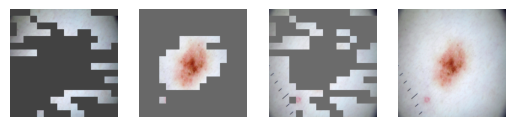

Testing:   1%|▊                                                                         | 7/618 [00:03<03:46,  2.70it/s]

<Figure size 1000x500 with 0 Axes>

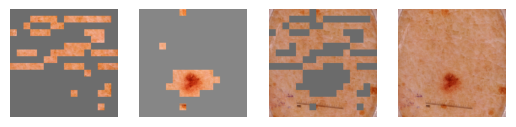

Testing:   1%|▉                                                                         | 8/618 [00:03<04:08,  2.46it/s]

<Figure size 1000x500 with 0 Axes>

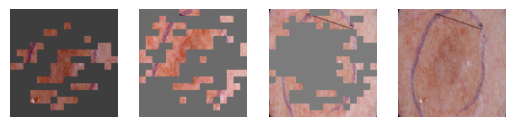

Testing:   1%|█                                                                         | 9/618 [00:04<03:57,  2.57it/s]

<Figure size 1000x500 with 0 Axes>

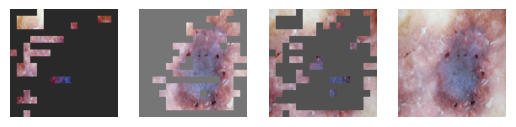

Testing:   2%|█▏                                                                       | 10/618 [00:04<03:27,  2.92it/s]

<Figure size 1000x500 with 0 Axes>

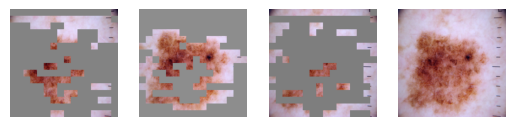

Testing:   2%|█▎                                                                       | 11/618 [00:04<03:07,  3.23it/s]

<Figure size 1000x500 with 0 Axes>

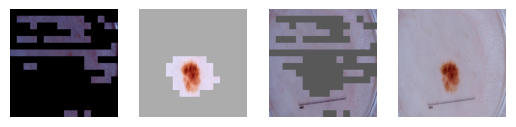

Testing:   2%|█▍                                                                       | 12/618 [00:05<03:42,  2.72it/s]

<Figure size 1000x500 with 0 Axes>

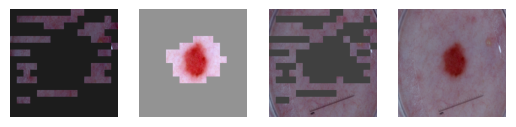

Testing:   2%|█▌                                                                       | 13/618 [00:05<03:42,  2.72it/s]

<Figure size 1000x500 with 0 Axes>

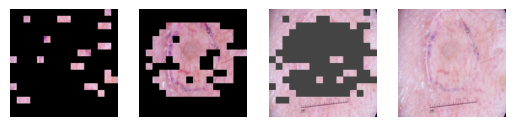

Testing:   2%|█▋                                                                       | 14/618 [00:05<03:57,  2.54it/s]

<Figure size 1000x500 with 0 Axes>

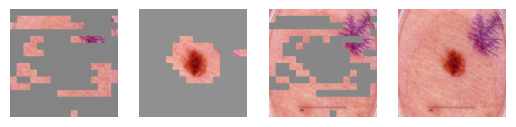

Testing:   2%|█▊                                                                       | 15/618 [00:06<04:34,  2.20it/s]

<Figure size 1000x500 with 0 Axes>

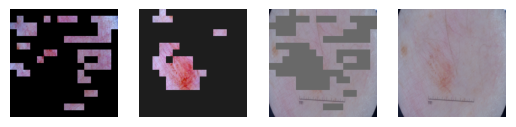

Testing:   3%|█▉                                                                       | 16/618 [00:07<04:35,  2.18it/s]

<Figure size 1000x500 with 0 Axes>

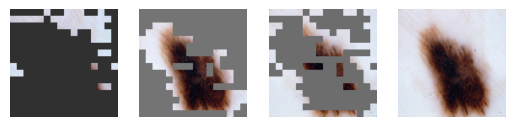

Testing:   3%|██                                                                       | 17/618 [00:07<06:05,  1.64it/s]

<Figure size 1000x500 with 0 Axes>

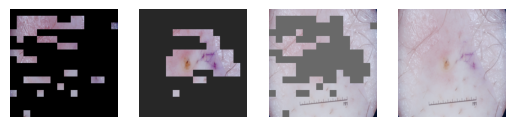

Testing:   3%|██▏                                                                      | 18/618 [00:08<05:30,  1.82it/s]

<Figure size 1000x500 with 0 Axes>

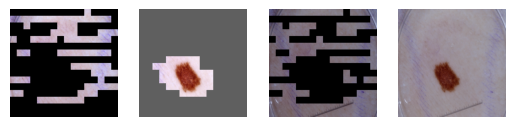

Testing:   3%|██▏                                                                      | 19/618 [00:08<05:17,  1.88it/s]

<Figure size 1000x500 with 0 Axes>

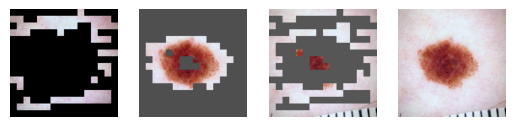

Testing:   3%|██▎                                                                      | 20/618 [00:09<04:23,  2.27it/s]

<Figure size 1000x500 with 0 Axes>

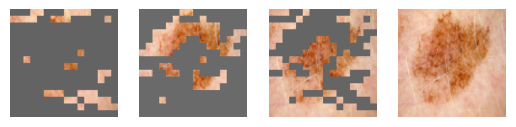

Testing:   3%|██▍                                                                      | 21/618 [00:09<03:45,  2.65it/s]

<Figure size 1000x500 with 0 Axes>

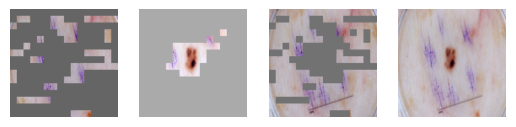

Testing:   4%|██▌                                                                      | 22/618 [00:09<03:40,  2.71it/s]

<Figure size 1000x500 with 0 Axes>

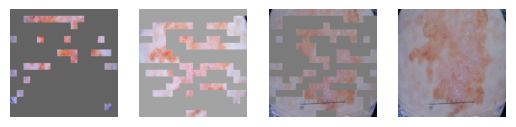

Testing:   4%|██▋                                                                      | 23/618 [00:10<04:01,  2.46it/s]

<Figure size 1000x500 with 0 Axes>

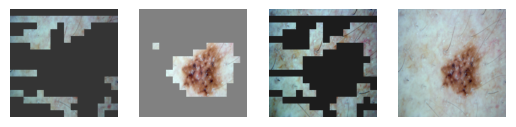

Testing:   4%|██▊                                                                      | 24/618 [00:10<03:29,  2.84it/s]

<Figure size 1000x500 with 0 Axes>

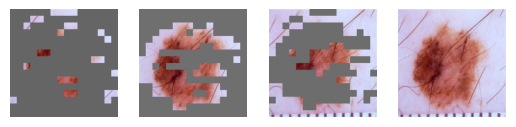

Testing:   4%|██▉                                                                      | 25/618 [00:10<03:06,  3.18it/s]

<Figure size 1000x500 with 0 Axes>

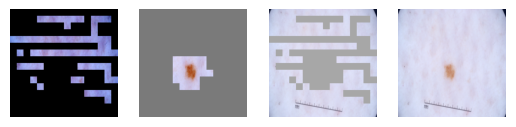

Testing:   4%|███                                                                      | 26/618 [00:11<03:31,  2.79it/s]

<Figure size 1000x500 with 0 Axes>

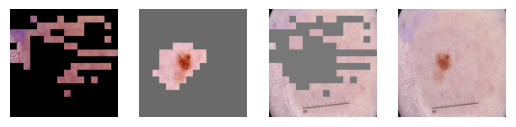

Testing:   4%|███▏                                                                     | 27/618 [00:11<03:53,  2.53it/s]

<Figure size 1000x500 with 0 Axes>

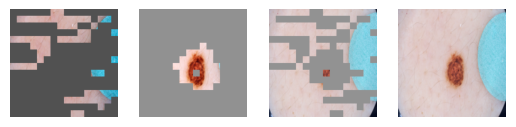

Testing:   5%|███▎                                                                     | 28/618 [00:12<04:07,  2.39it/s]

<Figure size 1000x500 with 0 Axes>

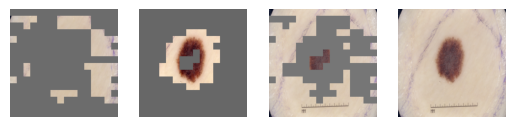

Testing:   5%|███▍                                                                     | 29/618 [00:12<04:17,  2.29it/s]

<Figure size 1000x500 with 0 Axes>

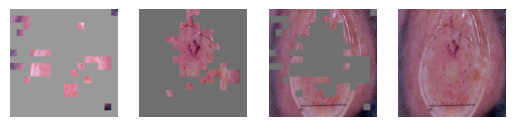

Testing:   5%|███▌                                                                     | 30/618 [00:13<05:04,  1.93it/s]

<Figure size 1000x500 with 0 Axes>

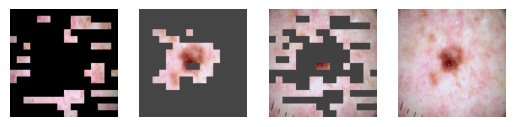

Testing:   5%|███▋                                                                     | 31/618 [00:13<04:12,  2.33it/s]

<Figure size 1000x500 with 0 Axes>

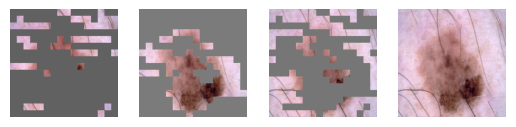

Testing:   5%|███▊                                                                     | 32/618 [00:14<05:46,  1.69it/s]

<Figure size 1000x500 with 0 Axes>

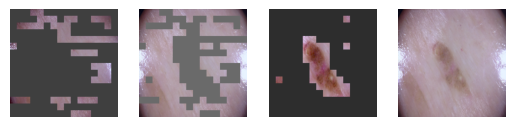

Testing:   5%|███▉                                                                     | 33/618 [00:14<04:57,  1.97it/s]

<Figure size 1000x500 with 0 Axes>

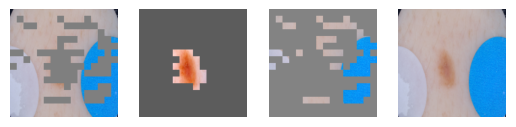

Testing:   6%|████                                                                     | 34/618 [00:15<04:53,  1.99it/s]

<Figure size 1000x500 with 0 Axes>

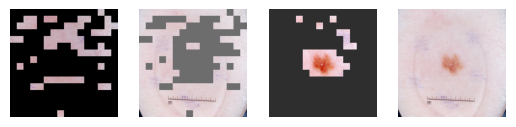

Testing:   6%|████▏                                                                    | 35/618 [00:15<04:36,  2.11it/s]

<Figure size 1000x500 with 0 Axes>

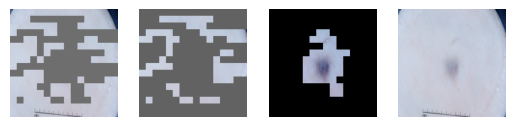

Testing:   6%|████▎                                                                    | 36/618 [00:16<04:26,  2.19it/s]

<Figure size 1000x500 with 0 Axes>

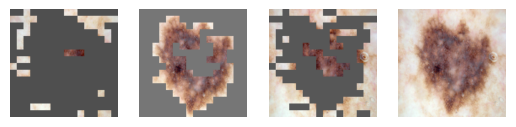

Testing:   6%|████▎                                                                    | 37/618 [00:16<03:48,  2.54it/s]

<Figure size 1000x500 with 0 Axes>

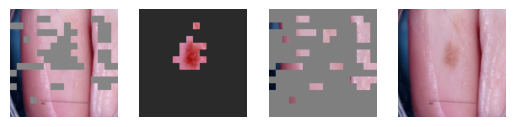

Testing:   6%|████▍                                                                    | 38/618 [00:16<03:40,  2.63it/s]

<Figure size 1000x500 with 0 Axes>

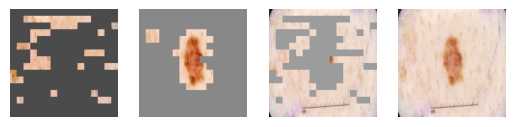

Testing:   6%|████▌                                                                    | 39/618 [00:17<03:56,  2.44it/s]

<Figure size 1000x500 with 0 Axes>

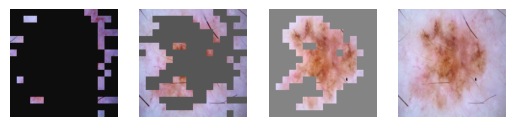

Testing: 100%|████████████████████████████████████████████████████████████████████████| 618/618 [03:43<00:00,  2.76it/s]

Accuracy for y=0, s=0: 0.665903890160183
Accuracy for y=0, s=1: 0.9454545454545454
Accuracy for y=1, s=0: 0.6428571428571429
Overall_Accuracy: 0.686084142394822


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.cluster import AgglomerativeClustering
from collections import deque


queue_length = 32

def pca_single_modality(pca_features, mask, n_imgs, img):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())
    plt.figure(figsize=(5, 5))
    
    for i in range(n_imgs):
        fig, ax = plt.subplots(1, 3)
        img[i] = (img[i] - img[i].min()) / (img[i].max() - img[i].min())
        image_np = to_pil_image(img[i].cpu().squeeze(0))
        ax[0].imshow(image_np)    
        print(pca_features[i*16*16 :(i+1)*16*16, :].shape)
        image_pca = torch.tensor(pca_features[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))                    
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))
    plt.show()
    plt.close()



def pca_single_modality_queue(pca_features, mask, n_imgs, img, id, imshow = False):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())

    if id < queue_length:
        image_pca = torch.tensor(pca_features[id*16*16 : (id + 1)*16*16, :].reshape(16,16, 3))    
    else:
        image_pca = torch.tensor(pca_features[-16*16 :, :].reshape(16,16, 3))

    if id < queue_length:
        mask_tensor = mask[id*16*16 : (id + 1)*16*16, :].reshape(16,16, 3)
    else:
        mask_tensor = mask[-16*16 :, :].reshape(16,16, 3)
    
    if imshow == True:
        plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots(1, 3)
        img = (img - img.min()) / (img.max() - img.min())
        image_np = to_pil_image(img.cpu().squeeze(0))
        ax[0].imshow(image_np)                 
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask_tensor)
        plt.show()
        plt.close()
    return mask_tensor


def masked_img(image, mask, imshow, prob):  # image: (3, 224, 224), mask: (16, 16, 3)
    to_pil_image = tfms.ToPILImage()
    mask_single_channel = torch.argmax(mask, dim=-1)  # Shape: [16, 16]
    mask_upsampled = F.interpolate(mask_single_channel.unsqueeze(0).unsqueeze(0).float(),
                                    size=(224, 224), mode="nearest").squeeze().long()  # Shape: [224, 224]
    binary_masks = [(mask_upsampled == value).float() for value in range(3)]
    masked_images = [image * binary_mask.unsqueeze(0) for binary_mask in binary_masks]
    normalized_images = []
    show_images = []
    for masked_image in masked_images:
        if masked_image.max() > masked_image.min():
            show_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())
            normalized_image = masked_image 
        else:
            normalized_image = masked_image  #
        normalized_images.append(normalized_image)
        show_images.append(show_image)
    if imshow == True:
        plt.figure(figsize=(10, 5))
        fig, ax = plt.subplots(1, 4)
        for i in range(3):
            image_np = to_pil_image(show_images[i].squeeze(0).cpu())
            ax[i].imshow(image_np)
            ax[i].axis('off')
        img = (image - image.min()) / (image.max() - image.min())
        image_np_o = to_pil_image(img.cpu().squeeze(0))
        ax[3].imshow(image_np_o) 
        ax[3].axis('off')
        plt.show()
    return normalized_images
    

def my_convert_ids_to_tokens(tokenizer, token_ids):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.tolist()
    
    tokens = []
    for tid in token_ids:
        if tid in tokenizer.decoder:
            tokens.append(tokenizer.decoder[tid])
        else:
            tokens.append(f"[UNK_{tid}]")
    return tokens

def fast_PCA(X):
    X = X.to(device)
    U, S, Vt = torch.svd_lowrank(X, q=10)
    k = 3
    PCs = Vt[:, :k] 
    X_pca = X @ PCs
    return X_pca





def test_epoch(vlm,   dataloader):  
    vlm = vlm.to(device)
    vlm.eval()   
    visual = vlm.visual
    vlm.visual.pool_type = None
    vlm.text_pool_type = 'last'
    T =1
    texts_label = ["A photo of benign melanoma.",  "A photo of malignant melanoma."] 
    general_label = ["A photo of melanoma."]
    text_label_tokened = tokenizer(texts_label).to(device)
    general_label_tokened = tokenizer(general_label).to(device)
    MOE_text_label_tokened = MOE_tokenizer(texts_label).to(device)
    MOE_general_label_tokened = MOE_tokenizer(general_label).to(device)
    length = 20
    text_embeddings = vlm.encode_text(text_label_tokened)#[:,:length,:]
    general_embeddings = vlm.encode_text(general_label_tokened)#[:,-1,:]
    MOE_text_embeddings = MOE_model.encode_text(MOE_text_label_tokened)
    MOE_general_embeddings = MOE_model.encode_text(MOE_general_label_tokened)
    print('general_embeddings', general_embeddings.shape)
    iteration = 0
    queue = deque()
    pca = PCA(n_components=3)
    img_show = 40
    correct_00, total_00 = 0, 0
    correct_01, total_01 = 0, 0
    correct_10, total_10 = 0, 0
    correct_11, total_11 = 0, 0
    segment_num = 3
    
    
    for _, (sample, _, _, _) in enumerate(tqdm(dataloader, desc="Testing")):
        sample = sample.to(device)
        img_embeds = vlm.encode_image(sample)[:,1:,:].squeeze(0)  
        img_embeds = img_embeds.detach().cpu().numpy()   
        queue.append(img_embeds)
        iteration += 1
        if iteration> queue_length:
            break
            
    iteration = 0
    for step, (_, test_target, sensitive_real, test_input) in enumerate(tqdm(dataloader, desc="Testing")):
        with torch.no_grad():  
            gt = test_target.detach().cpu().numpy()
            sen = sensitive_real.detach().cpu().numpy()   
            test_input = test_input.to(device)
            img_embeddings = vlm.encode_image(test_input)  #torch.Size([1, 257, 768])
            comb_feature_gpu = img_embeddings[:,1:,:].squeeze(0)
            comb_feature = comb_feature_gpu.detach().cpu().numpy() 

            if step < queue_length:
                combined_array = np.vstack(queue)
                
            else:            
                queue.popleft()
                queue.append(comb_feature)
                combined_array = np.vstack(queue)

            pca.fit(combined_array)
            pca_features = pca.transform(combined_array)
            smoothed_data = gaussian_filter(pca_features, sigma=(0.85, 0))
            kmean_cluster = KMeans(n_clusters=3, random_state=0, n_init="auto").fit_predict(smoothed_data)
            encoder = OneHotEncoder(sparse_output=False)
            one_hot_mask = encoder.fit_transform(kmean_cluster.reshape(-1, 1))
            pca_features_rgb = pca_features.copy()
            mask = pca_single_modality_queue(pca_features_rgb, one_hot_mask, batch_size, test_input, step)
            msks = masked_img(test_input.cpu(), torch.tensor(mask).cpu(), False, None)
            seg_embedding = torch.stack([MOE_model.encode_image(msk.to(device)) for msk in msks])####old code
            seg_embedding = seg_embedding.squeeze(1)
            seg_embedding = seg_embedding/seg_embedding.norm(dim=1, keepdim=True)
            MOE_general_embeddings = MOE_general_embeddings / MOE_general_embeddings.norm(dim=1, keepdim=True)
            seg_cosine_similarity = torch.mm(seg_embedding, MOE_general_embeddings.t()) 
            probs = seg_cosine_similarity.softmax(dim = 0)
            conf, predic = torch.max(probs.data, 0)
            if step < img_show:
                masked_img(test_input.cpu(), torch.tensor(mask).cpu(), True, probs)            
            high_attention_seg = msks[predic]
            high_embedding = MOE_model.encode_image(high_attention_seg.to(device))
            high_embedding = high_embedding.squeeze(1)
            high_embedding = high_embedding/high_embedding.norm(dim=1, keepdim=True)
            MOE_text_embeddings = MOE_text_embeddings/MOE_text_embeddings.norm(dim=1, keepdim=True)
            cosine_similarity = torch.mm(high_embedding, MOE_text_embeddings.t())
            logits_per_image = cosine_similarity 
            probs = logits_per_image.softmax(dim=1)
            _, predic = torch.max(probs.data, 1)
            predic = predic.detach().cpu()
            label = test_target.detach().cpu()

            mask_00 = ((label.squeeze() == 0) & (sensitive_real.squeeze() == 0))
            mask_01 = ((label.squeeze() == 0) & (sensitive_real.squeeze() == 1))
            mask_10 = ((label.squeeze() == 1) & (sensitive_real.squeeze() == 0))
            mask_11 = ((label.squeeze() == 1) & (sensitive_real.squeeze() == 1))


            correct_00 += (predic[mask_00] == label[mask_00]).float().sum().item()
            total_00 += mask_00.float().sum().item()
            correct_01 += (predic[mask_01] == label[mask_01]).float().sum().item()
            total_01 += mask_01.float().sum().item()
            correct_10 += (predic[mask_10] == label[mask_10]).float().sum().item()
            total_10 += mask_10.float().sum().item()
            correct_11 += (predic[mask_11] == label[mask_11]).float().sum().item()
            total_11 += mask_11.float().sum().item() 
            iteration +=1 

                
    acc_00 = correct_00 / total_00
    acc_01 = correct_01 / total_01
    acc_10 = correct_10 / total_10
    acc = (correct_00 + correct_01 + correct_10 + correct_11) / (total_00 + total_01 + total_10 + total_11)

    print(f'Accuracy for y=0, s=0: {acc_00}')
    print(f'Accuracy for y=0, s=1: {acc_01}')
    print(f'Accuracy for y=1, s=0: {acc_10}')
    print(f'Overall_Accuracy: {acc}')








seed_everything(2048)  
model = model.to(device)
model = model.eval()
test_epoch(model, test_data_loader)